This one was inspired by a conversation that happened at the 2020 RDKit (virtual) UGM. 

During Dominique Sydow's presentation she showed some pictures of molecules with some regions of the molecule highlighted (in her case to indicate which kinase pocket they interact with). Dominique had created the images by hand, but I wanted to explore what's possible using the 2020.09 RDKit release.

What this post is going to demonstrate is doing R-group decomposition (RGD) on a set of molecules that share a common scaffold, generating coordinates for those molecules that are aligned to the scaffold, and generating images of the molecules where the R groups are colored to make them easy to pick out.

The final images we create will look like this:

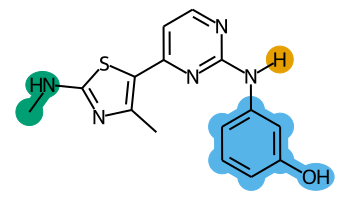

The rest of this post will go through the steps to create images like this.

Let's get started

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.molSize=(450,350)
from rdkit.Chem import rdRGroupDecomposition
from rdkit.Chem import rdqueries
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit import Geometry
rdDepictor.SetPreferCoordGen(True)
import pandas as pd

from IPython.display import SVG,Image
from ipywidgets import interact

import rdkit
print(rdkit.__version__)

2021.03.4


Start by reading in the data we will use. This is a collection of ChEMBL compounds with Ki data measured for CDK2. The dataset includes compounds from a number of different documents and, since these are medchem papers, many of the documents contain groups of compounds that share a common scaffold.

In [2]:
df = pd.read_csv('../data/cdk2_rgd_dataset.csv')
df.head()

,assay_id,doc_id,description,assay_organism,assay_chembl_id,aidx,pref_name,activity_id,molregno,standard_relation,...,src_id (#1),type,relation,value,units,text_value,standard_text_value,standard_inchi_key,canonical_smiles,compound_chembl_id
0,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,265814,68026,>,...,1,Ki,>,20.00,uM,NaN,NaN,RPXWUUDZINQPTJ-UHFFFAOYSA-N,CNc1nccc(n1)c2sc(C)nc2C,CHEMBL46474
1,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,265817,67880,=,...,1,Ki,=,0.14,uM,NaN,NaN,GDZTURHUKDAJGD-UHFFFAOYSA-N,Cc1nc(C)c(s1)c2ccnc(Nc3ccc(O)cc3)n2,CHEMBL442957
2,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,267078,67751,=,...,1,Ki,=,6.50,uM,NaN,NaN,CTFDMGIBHFQWKB-UHFFFAOYSA-N,Cc1nc(C)c(s1)c2ccnc(N)n2,CHEMBL47302
3,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,267081,67782,=,...,1,Ki,=,1.20,uM,NaN,NaN,HOKDXVAONYXHJK-UHFFFAOYSA-N,Cc1nc(C)c(s1)c2ccnc(Nc3ccccc3F)n2,CHEMBL297447
4,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,267084,67961,=,...,1,Ki,=,0.11,uM,NaN,NaN,XNKSRGHGPSHYIW-UHFFFAOYSA-N,CNc1nc(C)c(s1)c2ccnc(Nc3cccc(O)c3)n2,CHEMBL44119


We pick a group of compounds by selecting all the rows with a given assay ID:

In [3]:
df_doc1 = df[df.assay_chembl_id=='CHEMBL827377']
print(len(df_doc1))
df_doc1.head()

91


,assay_id,doc_id,description,assay_organism,assay_chembl_id,aidx,pref_name,activity_id,molregno,standard_relation,...,src_id (#1),type,relation,value,units,text_value,standard_text_value,standard_inchi_key,canonical_smiles,compound_chembl_id
47,302524,21080,Binding affinity for human cyclin-dependent ki...,Homo sapiens,CHEMBL827377,CLD0,Cyclin-dependent kinase 2,1438958,305637,>,...,1,Ki,>,19.95,uM,NaN,NaN,TWQUOUJLNRGSRZ-UHFFFAOYSA-N,Cc1ccc2c(c3ccnc(Nc4cccc(c4)C(F)(F)F)n3)c(nn2n1...,CHEMBL182493
48,302524,21080,Binding affinity for human cyclin-dependent ki...,Homo sapiens,CHEMBL827377,CLD0,Cyclin-dependent kinase 2,1438962,305651,>,...,1,Ki,>,19.95,uM,NaN,NaN,CYHPFZLFUXOCJJ-UHFFFAOYSA-N,Cc1ccc2c(c3ccnc(Nc4ccc(F)c(F)c4)n3)c(nn2n1)c5c...,CHEMBL182326
49,302524,21080,Binding affinity for human cyclin-dependent ki...,Homo sapiens,CHEMBL827377,CLD0,Cyclin-dependent kinase 2,1439061,305664,>,...,1,Ki,>,19.95,uM,NaN,NaN,MYSOMHSTKVRJRA-UHFFFAOYSA-N,Cc1ccc2c(c3ccnc(Nc4ccc5OCCOc5c4)n3)c(nn2n1)c6c...,CHEMBL183064
50,302524,21080,Binding affinity for human cyclin-dependent ki...,Homo sapiens,CHEMBL827377,CLD0,Cyclin-dependent kinase 2,1439063,305674,>,...,1,Ki,>,19.95,uM,NaN,NaN,VUGNSTAXWJUVEZ-UHFFFAOYSA-N,Cc1ccc2c(c3ccnc(Nc4ccc(Cl)c(c4)C(F)(F)F)n3)c(n...,CHEMBL361038
51,302524,21080,Binding affinity for human cyclin-dependent ki...,Homo sapiens,CHEMBL827377,CLD0,Cyclin-dependent kinase 2,1439065,305687,=,...,1,Ki,=,3.98,uM,NaN,NaN,BWBMBCPGRIOUNV-UHFFFAOYSA-N,C1CC1c2nn3ncccc3c2c4ccnc(Nc5ccccc5)n4,CHEMBL362296


Look at some of the compounds:

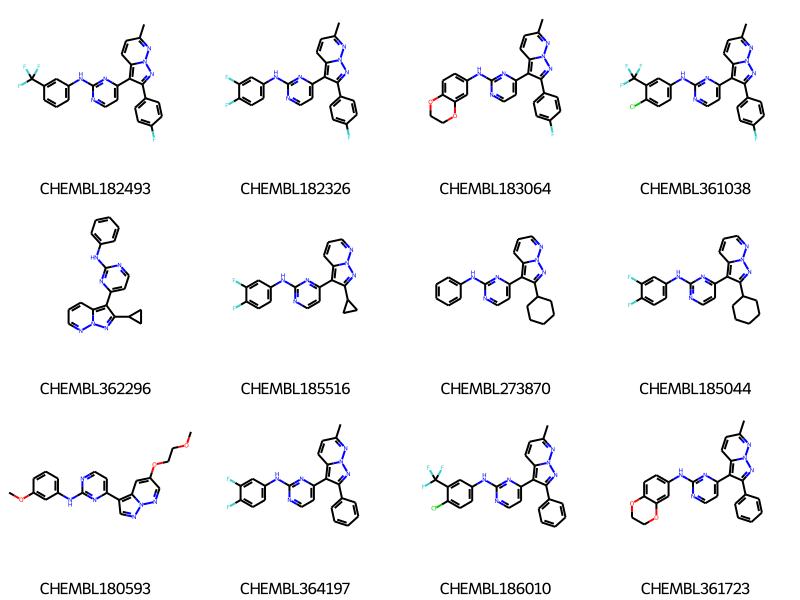

In [4]:
rdDepictor.SetPreferCoordGen(True)
smis = df_doc1['canonical_smiles']
cids = list(df_doc1.compound_chembl_id)
ms = [Chem.MolFromSmiles(x) for x in smis]
for m in ms:
    rdDepictor.Compute2DCoords(m)
Draw.MolsToGridImage(ms[:12],legends=cids,molsPerRow=4)

Define a core. I'm doing this manually and am only specifically labeling four of the seven R-groups in this set of molecules. The others will be labelled automatically by the RGD code. 

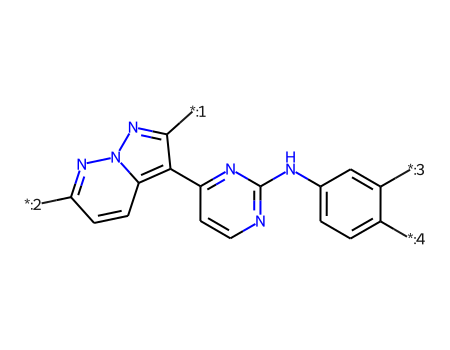

In [5]:
core = Chem.MolFromSmiles('c1cc(-c2c([*:1])nn3nc([*:2])ccc23)nc(N(c2ccc([*:4])c([*:3])c2))n1')
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(core)
core

Some pre-processing work we need to do:
- convert the dummy atoms in the scaffold into query atoms that match anything
- add hydrogens to the molecules
- select only the subset of molecules which match the core
- set a property on each atom which is used to track its original index (we use this later in the RGD analysis)

In [6]:
ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.makeDummiesQueries=True
qcore = Chem.AdjustQueryProperties(core,ps)
mhs = [Chem.AddHs(x,addCoords=True) for x in ms]
mms = [x for x in mhs if x.HasSubstructMatch(qcore)]
for m in mms:
    for atom in m.GetAtoms():
        atom.SetIntProp("SourceAtomIdx",atom.GetIdx())
print(len(mhs),len(mms))

91 91


Now do the actual RGD:

In [7]:
rdkit.RDLogger.DisableLog('rdApp.warning')
groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore],mms,asSmiles=False,asRows=True)

This is the function that actually does the work of generating aligned coordinates and creating the image with highlighted R groups

In [8]:
from collections import defaultdict

def highlight_rgroups(mol,row,core,width=350,height=200,
                      fillRings=True,legend="",
                      sourceIdxProperty="SourceAtomIdx",
                      lbls=('R1','R2','R3','R4')):
    # copy the molecule and core
    mol = Chem.Mol(mol)
    core = Chem.Mol(core)

    # -------------------------------------------
    # include the atom map numbers in the substructure search in order to 
    # try to ensure a good alignment of the molecule to symmetric cores
    for at in core.GetAtoms():
        if at.GetAtomMapNum():
            at.ExpandQuery(rdqueries.IsotopeEqualsQueryAtom(200+at.GetAtomMapNum()))
            
    for lbl in row:
        if lbl=='Core':
            continue
        rg = row[lbl]
        for at in rg.GetAtoms():
            if not at.GetAtomicNum() and at.GetAtomMapNum() and \
            at.HasProp('dummyLabel') and at.GetProp('dummyLabel')==lbl:
                # attachment point. the atoms connected to this
                # should be from the molecule
                for nbr in at.GetNeighbors():
                    if nbr.HasProp(sourceIdxProperty):
                        mAt = mol.GetAtomWithIdx(nbr.GetIntProp(sourceIdxProperty))
                        if mAt.GetIsotope():
                            mAt.SetIntProp('_OrigIsotope',mAt.GetIsotope())
                        mAt.SetIsotope(200+at.GetAtomMapNum())
    # remove unmapped hs so that they don't mess up the depiction
    rhps = Chem.RemoveHsParameters()
    rhps.removeMapped = False
    tmol = Chem.RemoveHs(mol,rhps)
    rdDepictor.GenerateDepictionMatching2DStructure(tmol,core)

    oldNewAtomMap={}
    # reset the original isotope values and account for the fact that
    # removing the Hs changed atom indices
    for i,at in enumerate(tmol.GetAtoms()):
        if at.HasProp(sourceIdxProperty):
            oldNewAtomMap[at.GetIntProp(sourceIdxProperty)] = i
            if at.HasProp("_OrigIsotope"):
                at.SetIsotope(at.GetIntProp("_OrigIsotope"))
                at.ClearProp("_OrigIsotope")
            else:
                at.SetIsotope(0)
      
    # ------------------
    #  set up our colormap
    #   the three choices here are all "colorblind" colormaps
    
    # "Tol" colormap from https://davidmathlogic.com/colorblind
    colors = [(51,34,136),(17,119,51),(68,170,153),(136,204,238),(221,204,119),(204,102,119),(170,68,153),(136,34,85)]
    # "IBM" colormap from https://davidmathlogic.com/colorblind
    colors = [(100,143,255),(120,94,240),(220,38,127),(254,97,0),(255,176,0)]
    # Okabe_Ito colormap from https://jfly.uni-koeln.de/color/
    colors = [(230,159,0),(86,180,233),(0,158,115),(240,228,66),(0,114,178),(213,94,0),(204,121,167)]
    for i,x in enumerate(colors):
        colors[i] = tuple(y/255 for y in x)
  
    #----------------------
    # Identify and store which atoms, bonds, and rings we'll be highlighting
    highlightatoms = defaultdict(list)
    highlightbonds = defaultdict(list)
    atomrads = {}
    widthmults = {}

    rings = []
    for i,lbl in enumerate(lbls):    
        color = colors[i%len(colors)]
        rquery = row[lbl]
        Chem.GetSSSR(rquery)
        rinfo = rquery.GetRingInfo()
        for at in rquery.GetAtoms():
            if at.HasProp(sourceIdxProperty):
                origIdx = oldNewAtomMap[at.GetIntProp(sourceIdxProperty)]
                highlightatoms[origIdx].append(color)
                atomrads[origIdx] = 0.4
        if fillRings:
            for aring in rinfo.AtomRings():
                tring = []
                allFound = True
                for aid in aring:
                    at = rquery.GetAtomWithIdx(aid)
                    if not at.HasProp(sourceIdxProperty):
                        allFound = False
                        break
                    tring.append(oldNewAtomMap[at.GetIntProp(sourceIdxProperty)])
                if allFound:
                    rings.append((tring,color))
        for qbnd in rquery.GetBonds():
            batom = qbnd.GetBeginAtom()
            eatom = qbnd.GetEndAtom()
            if batom.HasProp(sourceIdxProperty) and eatom.HasProp(sourceIdxProperty):
                origBnd = tmol.GetBondBetweenAtoms(oldNewAtomMap[batom.GetIntProp(sourceIdxProperty)],
                                                 oldNewAtomMap[eatom.GetIntProp(sourceIdxProperty)])
                bndIdx = origBnd.GetIdx()
                highlightbonds[bndIdx].append(color)
                widthmults[bndIdx] = 2

    d2d = rdMolDraw2D.MolDraw2DCairo(width,height)
    dos = d2d.drawOptions()
    dos.useBWAtomPalette()
                
    #----------------------
    # if we are filling rings, go ahead and do that first so that we draw
    # the molecule on top of the filled rings
    if fillRings and rings:
        # a hack to set the molecule scale
        d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),
                                       dict(highlightbonds),
                                       atomrads,widthmults)
        d2d.ClearDrawing()
        conf = tmol.GetConformer()
        for (aring,color) in rings:
            ps = []
            for aidx in aring:
                pos = Geometry.Point2D(conf.GetAtomPosition(aidx))
                ps.append(pos)
            d2d.SetFillPolys(True)
            d2d.SetColour(color)
            d2d.DrawPolygon(ps)
        dos.clearBackground = False

    #----------------------
    # now draw the molecule, with highlights:
    d2d.DrawMoleculeWithHighlights(tmol,legend,dict(highlightatoms),dict(highlightbonds),
                                   atomrads,widthmults)
    d2d.FinishDrawing()
    png = d2d.GetDrawingText()
    return png


Interactively try that out on all the molecules in our set:

In [9]:
@interact(idx=range(0,len(ms)))
def draw_it(idx=0):
    m = mms[idx]
    row = groups[idx]
    return Image(highlight_rgroups(m,row,qcore,lbls=('R1','R2','R3','R4')))


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

It would be cool to do see multiple molecules at once. Unforunately `DrawMolsToGridImage()` doesn't support the multiple highlighting we're doing here (we decided that the API for that would just be too complex; this may change in the future if we can figure out a sensible API for it), so we have to manually combine the images. Fortunately the pillow package makes that easy:

In [10]:
from PIL import Image as pilImage
from io import BytesIO

def draw_multiple(ms,groups,qcore,lbls,legends=None,nPerRow=4,subImageSize=(250,200)):
    nRows = len(ms)//nPerRow
    if len(ms)%nPerRow:
        nRows+=1
    nCols = nPerRow
    imgSize = (subImageSize[0]*nCols,subImageSize[1]*nRows)
    res = pilImage.new('RGB',imgSize)
    
    for i,m in enumerate(ms):
        col = i%nPerRow
        row = i//nPerRow
        if legends:
            legend = legends[i]
        else:
            legend = ''
        png = highlight_rgroups(m,groups[i],qcore,lbls=lbls,legend=legend,
                               width=subImageSize[0],height=subImageSize[1])
        bio = BytesIO(png)
        img = pilImage.open(bio)
        res.paste(img,box=(col*subImageSize[0],row*subImageSize[1]))
    bio = BytesIO()
    res.save(bio,format='PNG')
    return bio.getvalue()

Now let's look at the first 16 molecules in the dataset:

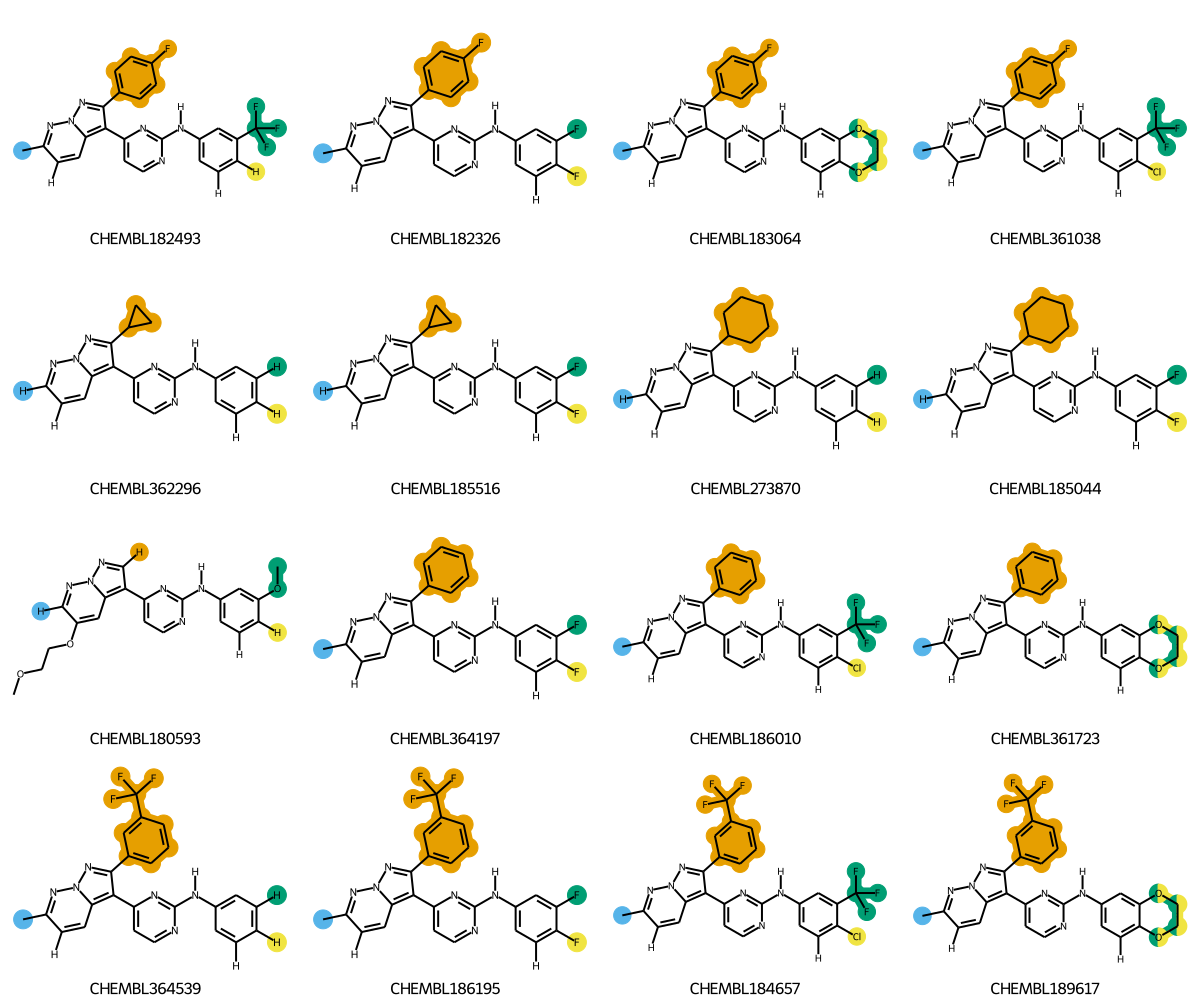

In [11]:
Image(draw_multiple(mms[:16],groups,qcore,('R1','R2','R3','R4'),legends=cids,subImageSize=(300,250)))

Repeat that analysis with the compounds from another document just to make sure we did everything sufficiently generally:

In [12]:
df_doc2 = df[df.assay_chembl_id=='CHEMBL658107']
print(len(df_doc2))
df_doc2.head()

33


,assay_id,doc_id,description,assay_organism,assay_chembl_id,aidx,pref_name,activity_id,molregno,standard_relation,...,src_id (#1),type,relation,value,units,text_value,standard_text_value,standard_inchi_key,canonical_smiles,compound_chembl_id
0,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,265814,68026,>,...,1,Ki,>,20.00,uM,NaN,NaN,RPXWUUDZINQPTJ-UHFFFAOYSA-N,CNc1nccc(n1)c2sc(C)nc2C,CHEMBL46474
1,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,265817,67880,=,...,1,Ki,=,0.14,uM,NaN,NaN,GDZTURHUKDAJGD-UHFFFAOYSA-N,Cc1nc(C)c(s1)c2ccnc(Nc3ccc(O)cc3)n2,CHEMBL442957
2,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,267078,67751,=,...,1,Ki,=,6.50,uM,NaN,NaN,CTFDMGIBHFQWKB-UHFFFAOYSA-N,Cc1nc(C)c(s1)c2ccnc(N)n2,CHEMBL47302
3,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,267081,67782,=,...,1,Ki,=,1.20,uM,NaN,NaN,HOKDXVAONYXHJK-UHFFFAOYSA-N,Cc1nc(C)c(s1)c2ccnc(Nc3ccccc3F)n2,CHEMBL297447
4,50641,17759,Inhibitory activity against human CDK2 (Cyclin...,NaN,CHEMBL658107,CLD0,Cyclin-dependent kinase 2,267084,67961,=,...,1,Ki,=,0.11,uM,NaN,NaN,XNKSRGHGPSHYIW-UHFFFAOYSA-N,CNc1nc(C)c(s1)c2ccnc(Nc3cccc(O)c3)n2,CHEMBL44119


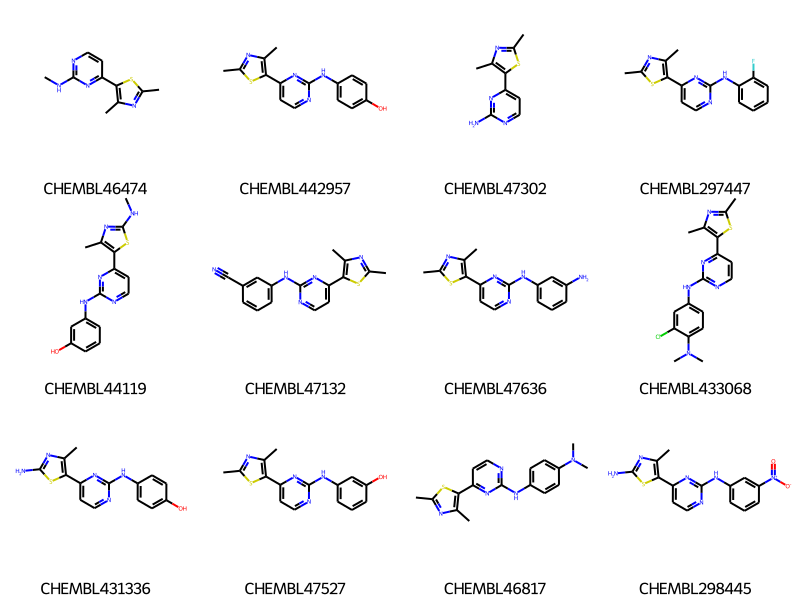

In [13]:
smis = df_doc2['canonical_smiles']
cids = list(df_doc2.compound_chembl_id)
ms = [Chem.MolFromSmiles(x) for x in smis]
for m in ms:
    rdDepictor.Compute2DCoords(m)
Draw.MolsToGridImage(ms[:12],legends=cids,molsPerRow=4)

33 33


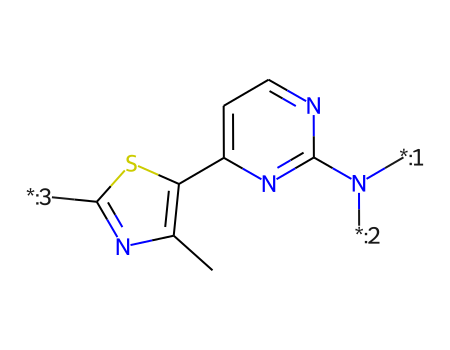

In [14]:
core = Chem.MolFromSmiles('Cc1nc([*:3])sc1-c1ccnc(N([*:1])[*:2])n1')
ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.makeDummiesQueries=True
qcore = Chem.AdjustQueryProperties(core,ps)
mhs = [Chem.AddHs(x,addCoords=True) for x in ms]
mms = [x for x in mhs if x.HasSubstructMatch(qcore)]
for m in mms:
    for atom in m.GetAtoms():
        atom.SetIntProp("SourceAtomIdx",atom.GetIdx())
print(len(mhs),len(mms))
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(qcore)
qcore

In [15]:
rdkit.RDLogger.DisableLog('rdApp.warning')
groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore],mms,asSmiles=False,asRows=True)

In [16]:
@interact(idx=range(0,len(mms)))
def draw_it(idx=0):
    m = mms[idx]
    row = groups[idx]
    return Image(highlight_rgroups(m,row,qcore,lbls=('R1','R2','R3')))


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

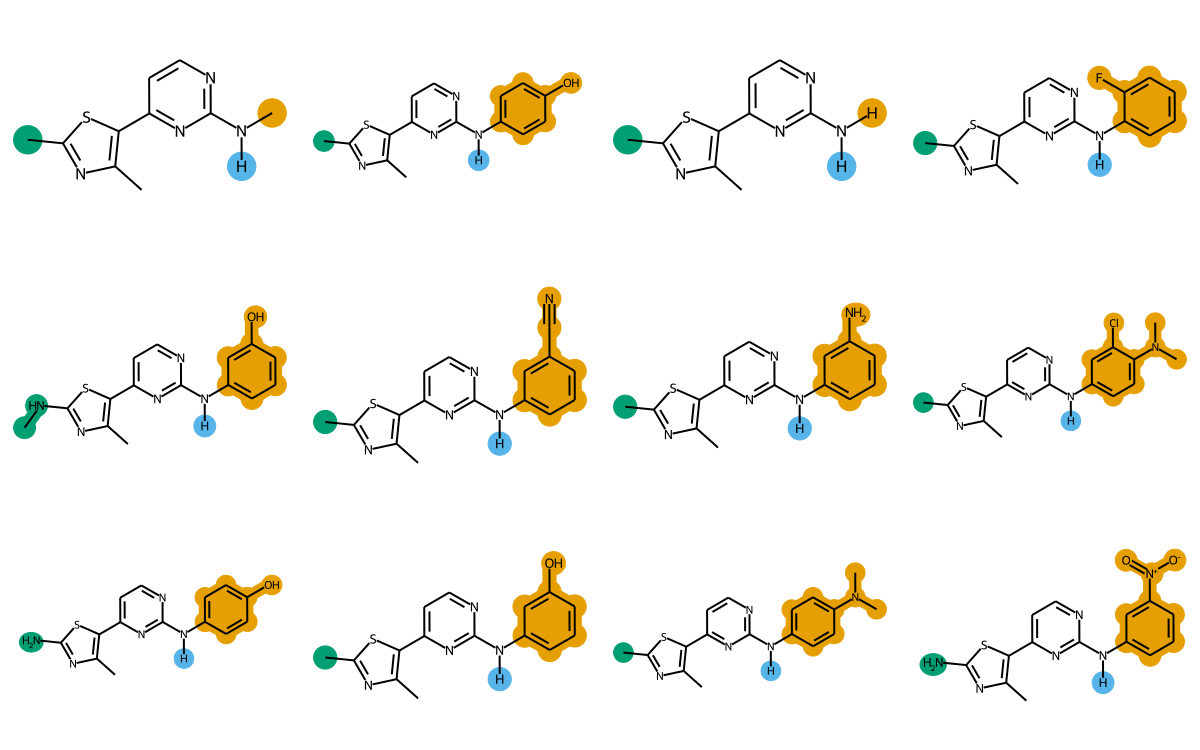

In [17]:
Image(draw_multiple(mms[:12],groups,qcore,('R1','R2','R3'),subImageSize=(300,250)))

In [18]:
df_doc3 = df[df.assay_chembl_id=='CHEMBL3101313']
print(len(df_doc3))
df_doc3.head()

25


,assay_id,doc_id,description,assay_organism,assay_chembl_id,aidx,pref_name,activity_id,molregno,standard_relation,...,src_id (#1),type,relation,value,units,text_value,standard_text_value,standard_inchi_key,canonical_smiles,compound_chembl_id
1129,1281340,76402,Displacement of B-Alexa-Fluor647 from CDK2 (un...,Homo sapiens,CHEMBL3101313,CLD0,Cyclin-dependent kinase 2,13859835,1610535,<,...,1,Ki,<,0.10,uM,NaN,NaN,USOUMMYIFYDJEI-ZZTDINLMSA-N,COC[C@H](Cc1ccc(O)cc1)NC(=O)c2cc(C(=O)O)c3cc(\...,CHEMBL3099753
1130,1281340,76402,Displacement of B-Alexa-Fluor647 from CDK2 (un...,Homo sapiens,CHEMBL3101313,CLD0,Cyclin-dependent kinase 2,13859836,1610534,=,...,1,Ki,=,0.10,uM,NaN,NaN,DLJWCYCMLMVSML-FQEVSTJZSA-N,COC[C@H](Cc1ccc(O)cc1)NC(=O)c2cc(C(=O)O)c3cc(c...,CHEMBL3099752
1131,1281340,76402,Displacement of B-Alexa-Fluor647 from CDK2 (un...,Homo sapiens,CHEMBL3101313,CLD0,Cyclin-dependent kinase 2,13859837,1610533,=,...,1,Ki,=,0.16,uM,NaN,NaN,BHBDKGIDYKROMY-BAJJQUEBSA-N,CN(C)C(=O)[C@H](Cc1ccc(O)cc1)NC(=O)c2cc(C(=O)O...,CHEMBL3099751
1132,1281340,76402,Displacement of B-Alexa-Fluor647 from CDK2 (un...,Homo sapiens,CHEMBL3101313,CLD0,Cyclin-dependent kinase 2,13859838,1610532,=,...,1,Ki,=,0.10,uM,NaN,NaN,IYRLCOILNQBJEJ-ZNOKPGKASA-N,CNC(=O)[C@H](Cc1ccc(O)cc1)NC(=O)c2cc(C(=O)O)c3...,CHEMBL3099750
1133,1281340,76402,Displacement of B-Alexa-Fluor647 from CDK2 (un...,Homo sapiens,CHEMBL3101313,CLD0,Cyclin-dependent kinase 2,13859839,1610531,=,...,1,Ki,=,0.30,uM,NaN,NaN,DDIHZTFUIFPFOO-OAQYLSRUSA-N,CCC[C@H](Cc1ccc(O)cc1)NC(=O)c2cc(C(=O)O)c3cc(c...,CHEMBL3099749


Finally, do another document, just because it's fun. :-)

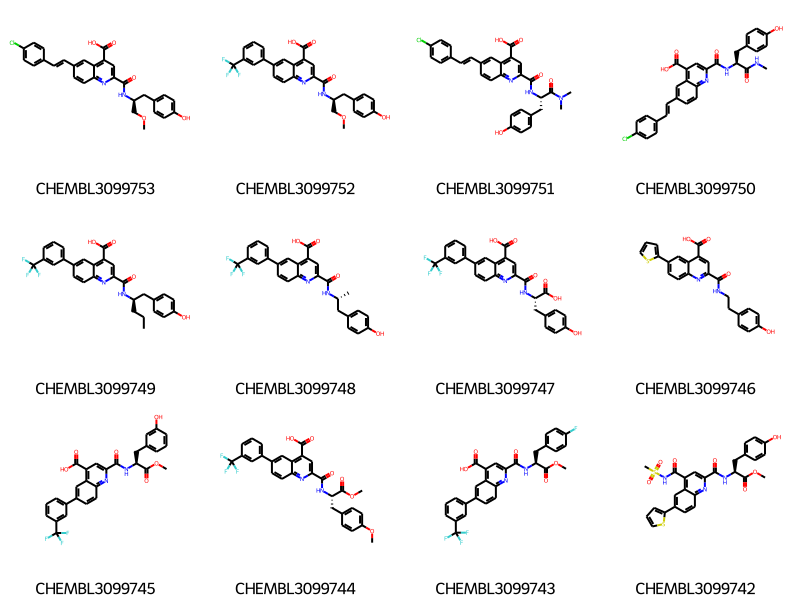

In [19]:
smis = df_doc3['canonical_smiles']
cids = list(df_doc3.compound_chembl_id)
ms = [Chem.MolFromSmiles(x) for x in smis]
for m in ms:
    rdDepictor.Compute2DCoords(m)
Draw.MolsToGridImage(ms[:12],legends=cids,molsPerRow=4)

25 22


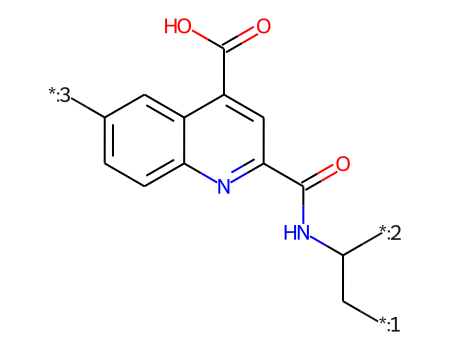

In [20]:
core = Chem.MolFromSmiles('OC(=O)c1cc(C(=O)NC(C[*:1])[*:2])nc2ccc([*:3])cc12')
ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.makeDummiesQueries=True
qcore = Chem.AdjustQueryProperties(core,ps)
mhs = [Chem.AddHs(x,addCoords=True) for x in ms]
mms = [x for x in mhs if x.HasSubstructMatch(qcore)]
for m in mms:
    for atom in m.GetAtoms():
        atom.SetIntProp("SourceAtomIdx",atom.GetIdx())
print(len(mhs),len(mms))
rdDepictor.SetPreferCoordGen(True)
rdDepictor.Compute2DCoords(qcore)
qcore

In [21]:
rdkit.RDLogger.DisableLog('rdApp.warning')
groups,_ = rdRGroupDecomposition.RGroupDecompose([qcore],mms,asSmiles=False,asRows=True)

In [22]:
@interact(idx=range(0,len(mms)))
def draw_it(idx=0):
    m = mms[idx]
    row = groups[idx]
    return Image(highlight_rgroups(m,row,qcore,lbls=('R1','R2','R3')))


interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

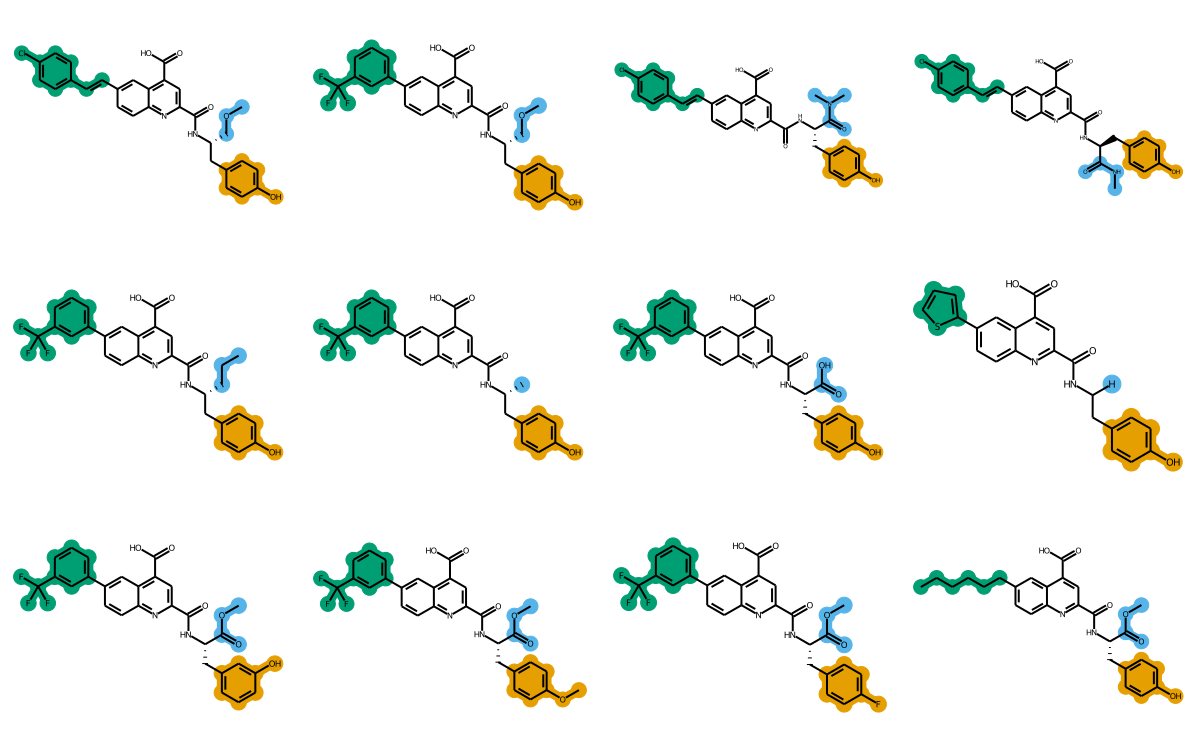

In [23]:
Image(draw_multiple(mms[:12],groups,qcore,('R1','R2','R3'),subImageSize=(300,250)))